# **VAD Comparison between 'The Hunger Games' novels and 'The Guardian' articles on Student Protest (2014-2025)**

**GitHub Repository Link:** https://github.com/hiladavies/thg

This notebook will explore the linguistic relationship between 'The Hunger Games' novels (Suzanne Collins) and 'The Guardian' articles about student protests from 2014-2025. Specifically, it will analyse whether there is a stastically relevant relationship between the two corpuses, using cosine similarity and VAD comparison. It will aim to ascertain the nature of this relationship to draw qualitative insights from the NLP methods.

This analysis is grounded in existing qualitative research conducted by the author on the impact of YA Dystopian Fiction, specifically 'The Hunger Games' novels, on the cultural vernacular of Gen Z. Previous study has found evidence that the novels are used by young people as a sense-making tool, particularly when describing socio-political changes. It suggests that its use as a sense-making tool is also mobilising youth and inspiring youth social action. 

Within this context, this study aims to complement existing research by analysing the relationship between fictional expressions of resistance in Collins’s novels and real-world youth protest discourse as reported by 'The Guardian'. It is important to consider 'The Guardian' articles as a separate audience to those involved in existing study as the writers of this discourse are not Gen Z. Therefore, analysis will show whether the novels' cultural influence has expanded this organic audience to effect mainstream linguistic descriptions of youth protest.


## **The Dataset**
The dataset for this study consists of two corpuses for comparison, and a pre-made VAD Lexicon.

**Hunger Games Quotes (`hg_quotes.csv`)**
A hand‐curated corpus of 267 key resistance‐themed lines from 'The Hunger Games' novels. The quotes were chosen through close literary reading using Barthes’s five codes, ensuring each line highlights culturally resonant themes of resistance rather than just plot details, aiming to reflect real-world protest discourse. Each row represents one quote, with columns for:
- `quote_text`: the full text of the line
- `speaker`: character who says the line
- `book`: which novel it appears in
- `chapter`: the chapter number
- `code`: the cultural code (Barthes) it has been assigned

**Guardian Protest Articles (`guardian_articles.csv`)**
A collection of 3000 news stories from 'The Guardian' collected through a scrape of 'The Guardian' Open Platform (https://open-platform.theguardian.com). Parameters included only English articles, that matched the search term of `student protests OR youth protests OR campus protest OR climate strike`. Articles were scraped from 2014 as this was the oldest records available. Each record contains:
- `title`: the article headline
- `section`: the section it was published in
- `date`: publication date
- `url`: original article link
- `byine`: article author
- `trailtext`: sub-heading
- `body`: raw HTML‐style article text

**VAD Lexicon (`vad.csv`)**
A psycholinguistic lookup table of ~20,000 English words, mapping each lowercased token to its mean Valence, Arousal, and Dominance scores. This allows us to compute and compare emotional profiles of both the quotes and the news articles.


In [1]:
import pandas as pd
import requests
import io
import spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
nlp = spacy.load("en_core_web_sm")
import re
import seaborn as sns
sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from IPython.display import IFrame
import plotly.express as px
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance
from IPython.display import IFrame


import nltk
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
import string
punct = list(string.punctuation)
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load THG quotes
df_quotes = pd.read_csv("thg_quotes.csv")
print(type(df_quotes))
quotes = df_quotes['quote_text'].tolist()

<class 'pandas.core.frame.DataFrame'>


In [4]:
df_quotes.tail()

,quote_text,speaker,chapter,book,code
261,"""But the Hunger Games are their weapon and you...",Katniss,26,The Hunger Games,Cultural
262,"""But I do notice they omit the part where I co...",Katniss,27,The Hunger Games,Not applicable
263,"""Thats when I know that even though both of u...",Katniss,27,The Hunger Games,Semic
264,"""I suspect Haymitch initially, but then there...",Katniss,27,The Hunger Games,Cultural
265,"""Its the Capitols way of reminding people th...",Katniss,27,The Hunger Games,Cultural


## **TF_IDF**

In [5]:
# Clean quotes and create lemmas

stops = set(stopwords.words('english'))
punct = set(string.punctuation).union({"‘", "’", "“", "”", "–", "—", "``", "''"})
contraction_frags = {"'s", "n't", "'ll", "'re", "'ve", "'m"}
lemmatizer = WordNetLemmatizer()

def normalize_quotes(text):
    return (text.replace("‘", "'")
                .replace("’", "'")
                .replace("“", '"')
                .replace("”", '"')
                .replace("\x92", "'"))

def good_tokens(text):
    text = normalize_quotes(text)
    words = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(w).lower() for w in words]
    filtered = [
        w for w in lemmas
        if w not in stops
           and w not in punct
           and w not in contraction_frags
           and len(w) >= 3
    ]
    return filtered

In [6]:
# Lemmas test
print(good_tokens(quotes[67]))

['minute', 'updated', 'told', 'rumor', 'uprising', 'districts', 'well', 'hunch', 'right', 'would', 'mean', 'almost', 'half', 'district', 'least', 'attempted', 'rebel']


In [7]:
# Load Guardian articles
df_guardian = pd.read_csv("guardian_master.csv")
df_guardian.tail()

,title,section,date,url,byline,trailText,body
2995,Lawyers to refuse criminal cases in protest ag...,Law,2015-06-25T18:55:17Z,https://www.theguardian.com/law/2015/jun/25/la...,Owen Bowcott,Decision by solicitors and barristers in Liver...,<p>Solicitors and barristers in Liverpool are ...
2996,This trade union bill will undermine our funda...,Opinion,2015-09-10T06:00:12Z,https://www.theguardian.com/commentisfree/2015...,Vince Cable and Frances O'Grady,Britain does not have a strike problem – so wh...,"<p>The Conservative <a href=""http://www.thegua..."
2997,'What happened to Sandy?': protesters tie Sand...,US news,2015-07-18T12:27:42Z,https://www.theguardian.com/us-news/2015/jul/1...,"Tom Dart in Hempstead, Texas",Demonstrators question official account that b...,"<aside class=""element element-rich-link elemen..."
2998,Reclaim Australia rallies: protesters clash in...,World news,2015-04-04T05:56:50Z,https://www.theguardian.com/australia-news/201...,Michael Safi and agencies,Former One Nation leader Pauline Hanson tells ...,<p>Hundreds of anti-Islam protesters have clas...
2999,Unprecedented dust storm sparks protests in we...,World news,2015-02-10T19:33:26Z,https://www.theguardian.com/world/iran-blog/20...,Saeed Kamali Dehghan,Stories of suffocating dust reported to be 66 ...,<p>A suffocating dust storm sweeping across we...


In [8]:
# Clean to just include body text
guardian_articles = df_guardian['body'].dropna().tolist()

In [9]:
# Clean body text for guardian_articles
import html

def strip_html_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean_text_for_tfidf(text):
    text = html.unescape(text)
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)
    text = text.replace("\u00a0", " ").replace("\x92", "'")
    text = re.sub(r'\b[a-zA-Z0-9]\b', ' ', text)
    return text

nlp_spacy = spacy.load(
    "en_core_web_sm",
    disable=["parser", "tagger", "attribute_ruler", "lemmatizer"]
)

def remove_named_entities_from_doc(doc):
    ents = {(ent.start, ent.end) for ent in doc.ents}
    return " ".join([tok.text for tok in doc if not any(s <= tok.i < e for s, e in ents)])

cleaned_guardian = []
for doc in nlp_spacy.pipe(
        (clean_text_for_tfidf(strip_html_tags(a)) for a in guardian_articles),
        batch_size=20,
        n_process=2
    ):
    cleaned_guardian.append(remove_named_entities_from_doc(doc))

guardian_articles = cleaned_guardian

In [10]:
import math

BATCH_SIZE  = 100
PIPE_BATCH  = 20
N_PROCESS   = 2

cleaned_guardian = []
total    = len(guardian_articles)
n_batches = math.ceil(total / BATCH_SIZE)

for i in range(n_batches):
    start = i * BATCH_SIZE
    end   = min(start + BATCH_SIZE, total)
    chunk = guardian_articles[start:end]

    for doc in nlp_spacy.pipe(
            (strip_html_tags(a) for a in chunk),
            batch_size=PIPE_BATCH,
            n_process=N_PROCESS
        ):
        cleaned_guardian.append(remove_named_entities_from_doc(doc))

guardian_articles = cleaned_guardian

In [11]:
print(guardian_articles[10])

Police unlawfully spied on children as young as taking part in     climate strike protest in , documents have shown . The previously unseen papers reveal the police were rebuked by the information commissioner ’    office ( ) for video surveillance of the protest , which was attended by children and young people . Ruling the data - gathering unlawful , the watchdog said the force had failed to consider the privacy rights of the children at the protest , and had not considered their entitlement to added data protections in light of their age . The reprimand was issued in but came to light only after     freedom of information request by the civil rights campaign group , which had made     complaint about the surveillance . “ Our complaint and the information commissioner ’    subsequent action sets an important precedent protecting children from unjustified political surveillance , ” said , the director of . “ The police ’    recording of children , peacefully demonstrating about enviro

In [12]:
# Tokenize and lemmatize
tokenized_quotes = [good_tokens(q) for q in quotes]
tokenized_guardian = [good_tokens(a) for a in guardian_articles]

In [13]:
# Lemmas test
print(good_tokens(guardian_articles[15]))
print(good_tokens(quotes[66]))

['may', 'bit', 'dramatic', 'news', 'police', 'given', 'power', 'shut', 'protest', 'disruption', 'begin', 'report', 'immediately', 'reminded', 'massacre', 'civil', 'authority', 'killed', 'injured', 'people', 'protesting', 'right', 'vote', 'article', 'follows', 'various', 'report', 'plan', 'limit', 'right', 'strike', 'course', 'founded', 'inception', 'partly', 'related', 'order', 'beacon', 'liberal', 'democracy', 'never', 'wavered', 'noble', 'intent', 'including', 'constantly', 'highlighting', 'vast', 'inequality', 'partly', 'created', 'austerity', 'programme', 'since', 'public', 'servant', 'lost', 'earnings', 'real', 'term', 'late', 'radical', 'anthropologist', 'said', 'important', 'people', 'society', 'paid', 'least', 'people', 'currently', 'striking', 'planning', 'correct', 'identify', 'government', 'public', 'order', 'bill', 'question', 'balance', 'right', 'police', 'need', 'power', 'curtail', 'right', 'protest', 'teach', 'law', 'however', 'surprising', 'draw', 'equivalence', 'right'

In [14]:
# Clean lemmas - Guardian

def clean_text_for_tfidf(text):
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'\b[a-zA-Z0-9]\b', ' ', text)
    return text

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{2,}\b',
    min_df=5,
    max_df=0.5
)

In [26]:
# TF-IDF for 'guardian_articles'

tfidf_docs = [" ".join(tokens) for tokens in tokenized_quotes + tokenized_guardian]

tfidf_docs = [clean_text_for_tfidf(doc) for doc in tfidf_docs]

X = vectorizer.fit_transform(tfidf_docs)

df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

n_q = len(quotes)
guardian_slice = df_tfidf.iloc[n_q:]
avg_score = guardian_slice.mean().sort_values(ascending=False)
print(avg_score.head(10))

student       0.041172
climate       0.030462
university    0.026591
say           0.022277
country       0.021549
city          0.019972
activist      0.019470
officer       0.019053
action        0.018882
campus        0.018672
dtype: float64


**Average TF-IDF Terms in Guardian Protest Articles**  
The TF-IDF analysis highlights the most representative words across 'The Guardian' corpus, with “student”, “climate”, and “university” leading the list, reflecting the essence of the corpus. This also confirms that the scrape has been successful in collecting articles around student/youth protest. The low scores indicate that these words are common across the corpus, and not distinctive.

In [25]:
# Clean Hunger Games Lemmas
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

def clean_text_for_tfidf(text):
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)
    text = re.sub(r'\b[a-zA-Z0-9]\b', ' ', text)
    return text

QUOTE_JUNK = {
    'peeta','capitol','panem','snow','katniss','effie','haymitch',
    'cato','thresh','clove','coin','prim','avoxes', 'said', 'say', 'saying', 'says'
}

custom_stop_list = list(set(ENGLISH_STOP_WORDS).union(QUOTE_JUNK))

# TF-IDF vectorizer for quotes
vectorizer_quotes = TfidfVectorizer(
    tokenizer=good_tokens,       
    stop_words=custom_stop_list, 
    min_df=1,                    
    max_df=1.0                  
)

cleaned_quotes = [clean_text_for_tfidf(q) for q in quotes]
Xq = vectorizer_quotes.fit_transform(cleaned_quotes)

df_quotes_tfidf = pd.DataFrame(
    Xq.toarray(),
    columns=vectorizer_quotes.get_feature_names_out()
)

mean_quote_terms = df_quotes_tfidf.mean(axis=0).sort_values(ascending=False).head(10)
print("Mean Hunger Games quote terms:")
print(mean_quote_terms)

Mean Hunger Games quote terms:
district     0.035641
people       0.027128
game         0.022438
know         0.018146
rebellion    0.017950
want         0.017422
like         0.016583
make         0.015859
rebel        0.014349
enemy        0.014319
dtype: float64


/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Average TF-IDF Terms in The Hunger Games Quotes**  
The TF-IDF analysis highlights the terms core to the trilogy's rhetoric around rebellion. Emphasis on `district` and `people` suggest an emphasis on place-based identity and solidarity in relation to resistance. The presence of verbs like `want` and `make` may reflect a sense of, or need for, agency within the quotes. Finally, the use of `like` suggests that many quotes are comparative between two objects. These scores sit in congruence with the cultural codes identified through close reading, particularly around collective action and intentional resistance to authority. 

**Beyond Raw NLP**  
While TF-IDF and cosine similarity surface high-weight terms like “district,” they treat these purely as string tokens, missing their deeper cultural resonance. In a literary close reading, these words carry rich metaphorical meaning, signifying social hierarchy and collective identity in a way that pure statistical methods cannot capture. By combining quantitative NLP with qualitative, context-aware interpretation, we may gain a more complete understanding of how fictional resistance language reflects and refracts real-world protest discourse. 

In [20]:
# Combine token lists
combined_tokens = tokenized_quotes + tokenized_guardian

docs = [" ".join(toks) for toks in combined_tokens]

def clean_text_for_tfidf(text):
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'\b[a-zA-Z0-9]\b', ' ', text)
    return text

docs = [clean_text_for_tfidf(d) for d in docs]

ARTICLE_JUNK = {
    'said', 'say', 'saying', 'says'
}

custom_stop_list = list(set(ENGLISH_STOP_WORDS).union(ARTICLE_JUNK))

## **Cosine Analysis**

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise     import cosine_similarity
import numpy as np

vectorizer = TfidfVectorizer(
    tokenizer=good_tokens,
    stop_words=custom_stop_list,
    min_df=5,
    max_df=0.5,
)
X = vectorizer.fit_transform(docs)    

n_q = len(tokenized_quotes)
X_q = X[:n_q]
X_g = X[n_q:]

mean_q = X_q.mean(axis=0).A          
mean_g = X_g.mean(axis=0).A

sim = cosine_similarity(mean_q, mean_g)[0,0]
print(f"Corpus-level cosine similarity: {sim:.3f}")


Corpus-level cosine similarity: 0.308


When we collapse all 'The Hunger Games' quotes into a single “average quote” TF-IDF vector and all Guardian protest articles into a single “average article” vector, their cosine similarity is **0.308**. This low-to-moderate score indicates that, while there is some overlap in resistance-related vocabulary between the fictional corpus and real-world protest reporting, the two corpora remain largely distinct in their overall word-usage patterns. Suzanne Collins’s narrative language only modestly intersects with the journalistic terminology of contemporary protest coverage. 

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


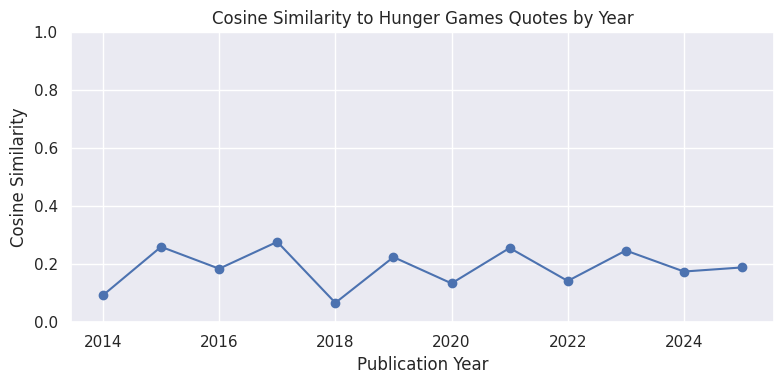

In [30]:
# Cosine‐similarity over time
df_g = (
    df_guardian
    .dropna(subset=['body', 'date'])
    .reset_index(drop=True)
)
guardian_articles = df_g['body'].tolist()
years_list        = pd.to_datetime(df_g['date']).dt.year.tolist()


docs = quotes + guardian_articles
vectorizer = TfidfVectorizer(
    tokenizer=good_tokens,
    stop_words=custom_stop_list,
    min_df=5,
    max_df=0.5
   
)
X = vectorizer.fit_transform(docs)       

n_q        = len(quotes)
X_arr      = X.toarray()                
X_quotes   = X_arr[:n_q, :]               
X_articles = X_arr[n_q:, :]                

quote_centroid = X_quotes.mean(axis=0).reshape(1, -1)  # (1 × V)

year_to_idxs = defaultdict(list)
for idx, yr in enumerate(years_list):
    year_to_idxs[yr].append(idx)

records = []
for yr in sorted(year_to_idxs):
    idxs = year_to_idxs[yr]
    year_centroid = X_articles[idxs, :].mean(axis=0).reshape(1, -1)
    sim = cosine_similarity(quote_centroid, year_centroid)[0, 0]
    records.append({'year': yr, 'similarity': sim})

sim_df = pd.DataFrame(records)

# Plot with Matplotlib
plt.figure(figsize=(8, 4))
plt.plot(sim_df['year'], sim_df['similarity'], marker='o')
plt.title('Cosine Similarity to Hunger Games Quotes by Year')
plt.xlabel('Publication Year')
plt.ylabel('Cosine Similarity')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## **Topic Modelling**

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

docs = [" ".join(toks) for toks in tokenized_quotes + tokenized_guardian]

count_vect = CountVectorizer(
    tokenizer=good_tokens,
    stop_words=custom_stop_list, 
    min_df=5
)
X_counts = count_vect.fit_transform(docs)

n_topics = 6
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='batch',
    random_state=0
)
lda.fit(X_counts)

feature_names = count_vect.get_feature_names_out()
n_top_words  = 2

for ti, comp in enumerate(lda.components_):
    terms = [feature_names[i] for i in comp.argsort()[-n_top_words:][::-1]]
    print(f"Topic {ti+1}: {' '.join(terms)}")

doc_topic = lda.transform(X_counts) 

n_q = len(tokenized_quotes)
df_topics = pd.DataFrame(
    doc_topic,
    columns=[f"Topic {i+1}" for i in range(n_topics)]
)
df_topics['corpus'] = ['HG']*n_q + ['Guardian']*(len(docs)-n_q)

topic_summary = df_topics.groupby('corpus').mean()
print("\nAverage topic proportions by corpus:\n", topic_summary)

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Topic 1: climate protest
Topic 2: government updated
Topic 3: people case
Topic 4: people woman
Topic 5: police protest
Topic 6: student university

Average topic proportions by corpus:
            Topic 1  Topic 2   Topic 3   Topic 4   Topic 5   Topic 6
corpus                                                             
Guardian  0.190990  0.10595  0.080383  0.228586  0.266261  0.127829
HG        0.057506  0.06379  0.087659  0.643438  0.112437  0.035170


### **Topic Modeling Insights**  
By using topic modelling, six latent themes are drawn out:

1. **Topic 1 (climate protest)**  
2. **Topic 2 (government updated)**  
3. **Topic 3 (people case)**  
4. **Topic 4 (people woman)**  
5. **Topic 5 (police protest)**  
6. **Topic 6 (student university)**  

When we examine how these themes distribute on average across the two corpora, we see:
- **Guardian articles** are more evenly spread across **people-woman**, **police-protest**, and **climate-government themes**, with a moderate focus on student/university coverage. This is especially intriguing considering that the corpus was chosen for its emphasis on student protests, suggesting that the themes of the articles different from their topic.  
- **Hunger Games quotes** concentrate heavily on the **people-woman**, with some emphasis on **police-protest**. This reflects the corpus' emphasis on collective action, and its narrator as a female voice. Topic proportions towards direct challenges to authority such as the police and protest are comparatively higher in news coverage. However, we must also consider that terms in the quotes corpus that would reflect themes around policing may use specific terms relating to the fictional world instead ('peacekeepers' etc.), which may not come up during topic-modelling. 

However, it is important to note that only of the six topics ever dominates more than half the corpus - the quotes and Topic 4. The Guardian articles are more evenly spread (top topics around 20%) while The Hunger Games quotes sit on extreme ends (0.03 - 0.6). As no Guardian proportion is about 26%, it suggests that thematic diversity is high. The low proportions thus illustrate both the multiplicity of protest-related themes and the differing focal points of fictional vs. journalistic discourse. 

## **VAD Analysis**  
 
With these results in mind, we will now conduct VAD analysis to ascertain whether there is similarity in the Valence, Arousal, or Dominance of the words used, beyond the themes brought out through topic modelling. This will allow us to better understand if there is an emotional similarity between the two corpora.

In [32]:
# Compute VAD

vad_df = pd.read_csv("vad.csv")
vad_df = vad_df.rename(columns={
    "V.Mean.Sum": "Valence",
    "A.Mean.Sum": "Arousal",
    "D.Mean.Sum": "Dominance",
    "Word": "word"
})
vad_df["word"] = vad_df["word"].str.lower()

vad_df = (
    vad_df
    .groupby("word", as_index=False)[["Valence","Arousal","Dominance"]]
    .mean()
)

vad_dict = vad_df.set_index("word")[["Valence","Arousal","Dominance"]].to_dict("index")

def compute_vad(tokens):
    scores = [vad_dict[w] for w in tokens if w in vad_dict]
    if not scores:
        return pd.Series({"Valence":None, "Arousal":None, "Dominance":None})
    vals = pd.DataFrame(scores)
    return pd.Series({
        "Valence":   vals["Valence"].mean(),
        "Arousal":   vals["Arousal"].mean(),
        "Dominance": vals["Dominance"].mean()
    })

# Apply to Hunger Games quotes
df_quotes["tokens"] = df_quotes["quote_text"].apply(good_tokens)
vad_quotes = df_quotes["tokens"].apply(compute_vad)
df_quotes = pd.concat([df_quotes, vad_quotes], axis=1)
df_quotes["corpus"] = "HungerGames"

# Apply to Guardian articles
df_guardian_vad = pd.DataFrame({"tokens": tokenized_guardian})
vad_guardian = df_guardian_vad["tokens"].apply(compute_vad)

df_guardian_vad = pd.concat([df_guardian.reset_index(drop=True), vad_guardian], axis=1)
df_guardian_vad["corpus"] = "Guardian"


compare_df = pd.concat([
    df_quotes[["quote_text","corpus","Valence","Arousal","Dominance"]],
    df_guardian_vad[["body","corpus","Valence","Arousal","Dominance"]]
        .rename(columns={"body":"text"})
], ignore_index=True)


print(compare_df.groupby("corpus")[["Valence","Arousal","Dominance"]].mean())

              Valence   Arousal  Dominance
corpus                                    
Guardian     0.544907  0.402201   0.548858
HungerGames  0.557024  0.413052   0.550211


In [ ]:
# Plot VAD
df_q = (
    df_quotes
    .rename(columns={'quote_text':'text'})
    [['text','corpus','Valence','Arousal','Dominance']]
)

df_g = (
    df_guardian_vad
    .rename(columns={'body':'text'})
    [['text','corpus','Valence','Arousal','Dominance']]
)

compare_df = pd.concat([df_q, df_g], ignore_index=True)

import plotly.express as px

fig = px.scatter_3d(
    compare_df,
    x='Valence',
    y='Arousal',
    z='Dominance',
    color='corpus',
    hover_name='text',    
    title='3D VAD Space: Hunger Games Quotes vs. Guardian Articles'
)
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

In [ ]:
# Visualise distributions
for dim in ["Valence","Arousal","Dominance"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=compare_df, x="corpus", y=dim)
    plt.title(f"{dim} distribution by Corpus")
    plt.show()

### **VAD Analysis**

Visually, we can see that the Hunger Games quotes have greater VAD diversity than The Guardian articles, in congruence to insights drawn out from topic modelling which showed that the quotes had more thematic variation. Unsuprisingly, the articles have very few outliers, matching assumptions about the uniformity of journalistic style and tone in comparison to fiction. However, it is important to emphasise the linearality between the two corpora using this model - there seems to be a universal language of emotion between the corpora: 

- **Valence and arousal**: as texts become more positive (higher Valence), they tend to be less emotionally intense (lower Arousal). Conversely, the most rousing, high-arousal passages are also the most negative.  
- **Dominance grows with positivity**: more positive quotes (and articles) are also those where speakers or subjects feel more in control.  

It also shows that, on average, 'The Hunger Games' quotes are slightly more positive (Valence ≈ 0.557 vs. 0.545) and more emotionally charged (Arousal ≈ 0.413 vs. 0.402) than Guardian protest articles, while both corpora express a nearly identical sense of agency (Dominance ≈ 0.550 vs. 0.549).

Valence, arousal, and dominance in journalistic discourse on student protests and fictional depictions of rebellion aren’t independent; they co-vary along a single continuum of “intense negativity” and “calm positivity,” with fiction amplifying both poles more dramatically than journalism. The near‐identical mid‐range Valence (≈0.55) and Dominance (≈0.55) scores for both 'The Hunger Games' quotes and Guardian protest articles indicate a shared emotional register of agency and mild positivity in how resistance is framed. However, the novels exhibit significantly higher Arousal (≈0.413 vs. 0.402) and greater variance in Valence and Arousal, reflecting fiction’s tendency to dramatise rebellion more intensely than journalism. These patterns support a model of selective resonance: while Collins’s narrative rhetoric and real-world reporting draw from the same affective core of resistance, journalistic discourse softens the emotional extremes present in the novels. This duality underscores the need to combine quantitative VAD analysis with qualitative close reading to fully capture how fictional protest language both echoes and diverges from its real-world counterpart. 


## **VAD Changes over Time**

As our article data spans nearly 10 years, we can use the date of publication information to see whether the VAD of the articles, or their relationship with 'The Hunger Games' has varied at all over time.

In [ ]:
# Clean 'date' column

df_guardian['date'] = pd.to_datetime(df_guardian['date'])

df_guardian['year'] = df_guardian['date'].dt.year

counts = df_guardian['year'].value_counts().sort_index()
print(counts)

Straight away we can see that some years (2014, 2016, 2018, 2020, and 2022) had significantly less articles. It will be important to keep this in mind when analysing the data. 

In [ ]:
# VAD over time for just Guardian corpus

df_guardian_vad['date'] = pd.to_datetime(df_guardian_vad['date'])

df_guardian_vad['year'] = df_guardian_vad['date'].dt.year

yearly_vad = (
    df_guardian_vad
    .groupby('year')[['Valence','Arousal','Dominance']]
    .mean()
    .reset_index()
)

# Plot the trends over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_vad, x='year', y='Valence', marker='o', label='Valence')
sns.lineplot(data=yearly_vad, x='year', y='Arousal', marker='o', label='Arousal')
sns.lineplot(data=yearly_vad, x='year', y='Dominance', marker='o', label='Dominance')
plt.title('Mean VAD Scores for Guardian Protest Articles Over Time')
plt.xlabel('Publication Year')
plt.ylabel('Mean VAD Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Boxplots to see distribution shifts by year
for dim in ['Valence','Arousal','Dominance']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_guardian_vad, x='year', y=dim)
    plt.title(f'{dim} Distribution by Year')
    plt.xlabel('Publication Year')
    plt.ylabel(dim)
    plt.show()

There is an almost indistinguishable difference in the average VAD score overtime for the articles. As the graph shows, there is a slight change in 2018, but this should be disregarded due to the low number of collected articles published in 2018 within the corpus. While we can see that the boxplots show slight differences year by year in the variance of VAD, this likely reflects the natural changes in language in congruence with different political events throughout the time period. 

## **Conclusions**

Through the combination of NLP methods used in this study, several conclusions can be drawn. Firstly, that while the novels and the articles may have little lexical overlap, their semantic overlap may be much higher. However, to draw out these semantic conclusions, close-text, qualitative methods such as Barthes' 5 cultural codes are better equipped to draw out similarity in meaning. While topic modelling suggests that only themes around students and protest are present in the quote corpus, a closer understanding of the metaphprical and allegorical meaning of terms used in the corpus may suggest different themes, possibly with a higher similarity to the article corpus. The similarity in VAD scores between the two corpora further this hypothesis, as it reveals how the pathos between them are highly similar. Therefore, in answering the question around the relationship between YA dystopian fiction and mainstream reporting of youth protest, this analysis is the most relevant as it captures the similar essence between the corpora. However, it confirms that this relationship may be less tangible than hypothesised. By analysing both cosine similarity and VAD changes over time, we can see that there is little variance, in high contrast with the use of YA dystopian fiction as a sense-making tool for young people which has increased exponentially since 2020. Therefore, this reveals that the relationship may be more complex, and thus, conclusive insights cannot be drawn from using exclusively these results.

Further investigation may therefore benefit by using a mixed-methods approach, leaning into more qualitative methods to draw clearer conclusions from the NLP. It may also be necessary to widen the corpora, including different mainstream media sources that adopt varying journalistic tones to confirm conclusively the impact of journalistic discourse on the cosine disparity. 